<a href="https://colab.research.google.com/github/jmParkGit/Colab/blob/main/Sparta_Basic-machineLearning/hw4_%ED%92%8D%EA%B2%BD%EC%82%AC%EC%A7%84%EC%98%88%EC%B8%A1(ResNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 풍경사진 예측(ResNet)

## 데이터섯 다운로드
풍경 사진 데이터셋   
https://www.kaggle.com/puneet6060/intel-image-classification

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'USER' # username
os.environ['KAGGLE_KEY'] = 'KEY' # key

In [2]:
!kaggle datasets download -d puneet6060/intel-image-classification

 96% 332M/346M [00:02<00:00, 164MB/s]
100% 346M/346M [00:02<00:00, 160MB/s]


In [3]:
!unzip -q intel-image-classification.zip

## 패키지 로드

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

## 이미지 증강 기법

In [5]:
train_datagen = ImageDataGenerator(
  rescale=1./255, # 일반화
  rotation_range=10, # 랜덤하게 이미지를 회전 (단위: 도, 0-180)
  zoom_range=0.1, # 랜덤하게 이미지 확대 (%)
  width_shift_range=0.1,  # 랜덤하게 이미지를 수평으로 이동 (%)
  height_shift_range=0.1,  # 랜덤하게 이미지를 수직으로 이동 (%)
  horizontal_flip=True # 랜덤하게 이미지를 수평으로 뒤집기
)

test_datagen = ImageDataGenerator(
  rescale=1./255 # 일반화
)

train_gen = train_datagen.flow_from_directory(
  'seg_train/seg_train',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=True
)

test_gen = test_datagen.flow_from_directory(
  'seg_test/seg_test',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=False
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [6]:
from pprint import pprint
pprint(train_gen.class_indices)

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}


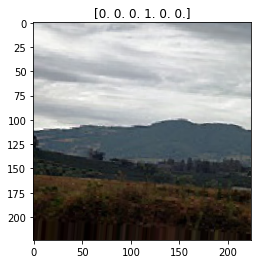

In [7]:
preview_batch = train_gen.__getitem__(0)

preview_imgs, preview_labels = preview_batch

plt.title(str(preview_labels[0]))
plt.imshow(preview_imgs[0])

## 전이학습
https://keras.io/api/applications/

In [8]:
from tensorflow.keras.applications import ResNet50

input = Input(shape=(224, 224, 3))

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input, pooling='max')

x = base_model.output
x = Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
output = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## 학습
ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)

val_acc가 높은 1개의 모델(save_best_only)을 model.h5 라는 파일로 저장한다.

https://keras.io/api/callbacks/model_checkpoint/

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = model.fit(
    train_gen,
    validation_data=test_gen, # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
    epochs=20, # epochs 복수형으로 쓰기!
    callbacks=[
      ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)
    ]
)

Epoch 1/20
439/439 [==============================] - 372s 760ms/step - loss: 0.9046 - acc: 0.7861 - val_loss: 1.7752 - val_acc: 0.1893

Epoch 00001: val_acc improved from -inf to 0.18933, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
439/439 [==============================] - 330s 750ms/step - loss: 0.4241 - acc: 0.8607 - val_loss: 0.7057 - val_acc: 0.7450

Epoch 00002: val_acc improved from 0.18933 to 0.74500, saving model to model.h5
Epoch 3/20
439/439 [==============================] - 330s 751ms/step - loss: 0.3581 - acc: 0.8788 - val_loss: 1.7577 - val_acc: 0.5567

Epoch 00003: val_acc did not improve from 0.74500
Epoch 4/20
439/439 [==============================] - 330s 750ms/step - loss: 0.3326 - acc: 0.8836 - val_loss: 0.5054 - val_acc: 0.8177

Epoch 00004: val_acc improved from 0.74500 to 0.81767, saving model to model.h5
Epoch 5/20
439/439 [==============================] - 330s 751ms/step - loss: 0.3068 - acc: 0.8939 - val_loss: 0.8042 - val_acc: 0.7190

Epoch 00005: val_acc did not improve from 0.81767
Epoch 6/20
439/439 [==============================] - 330s 750ms/step - loss: 0.3072 - acc: 0.8906 - val_loss: 1.7848 - val_acc: 0.5837

Epoch 00006: val_acc did not improve from 0.81767
Epoch

## 학습 결과 그래프

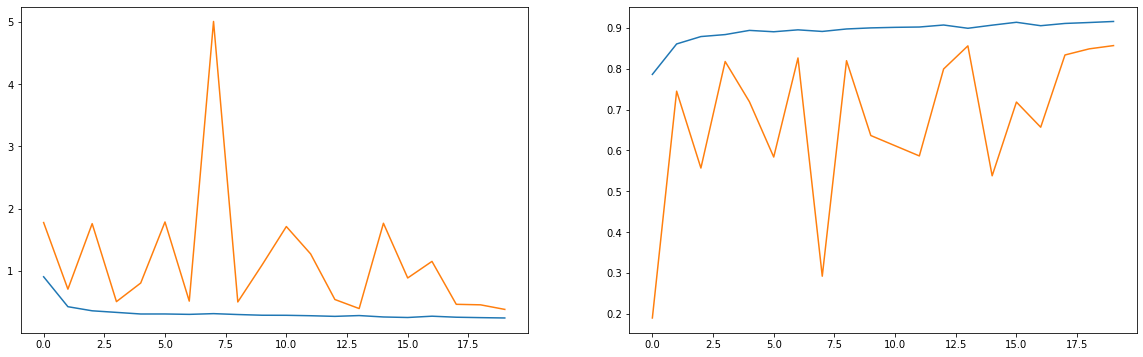

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[1].plot(history.history['acc'])
axes[1].plot(history.history['val_acc'])

## 학습된 모델 로드

In [11]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

print('Model loaded!')

Model loaded!


## 테스트

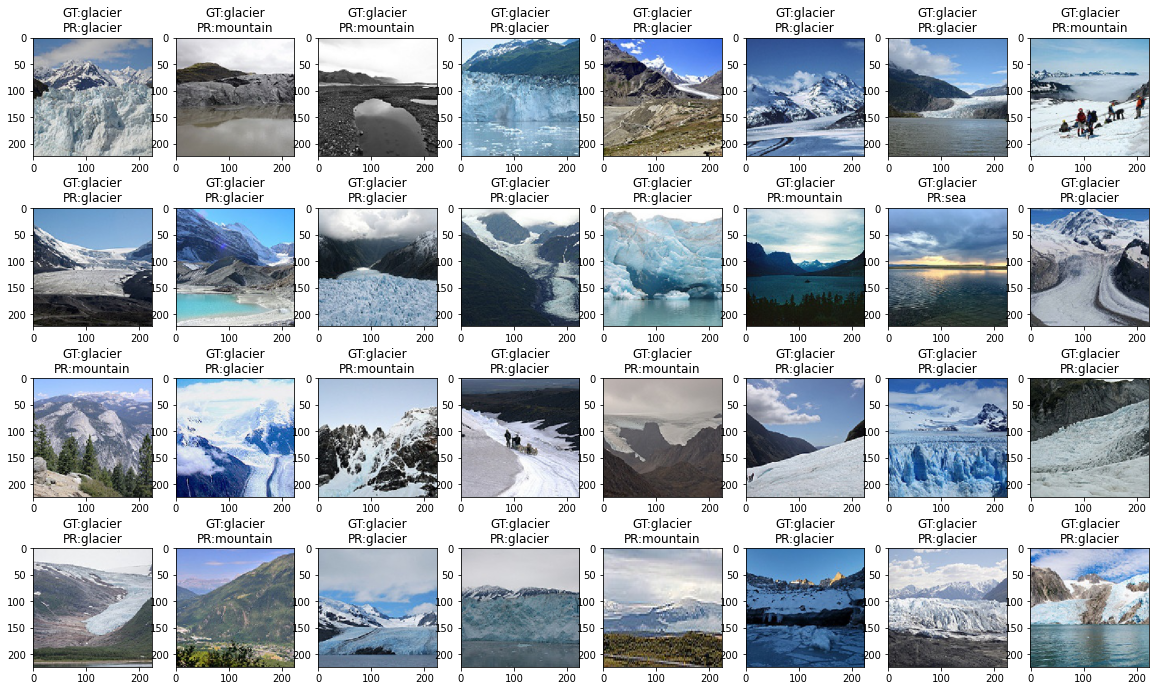

In [13]:
test_imgs, test_labels = test_gen.__getitem__(40)

y_pred = model.predict(test_imgs)

classes = dict((v, k) for k, v in test_gen.class_indices.items())

fig, axes = plt.subplots(4, 8, figsize=(20, 12))

for img, test_label, pred_label, ax in zip(test_imgs, test_labels, y_pred, axes.flatten()):
  test_label = classes[np.argmax(test_label)]
  pred_label = classes[np.argmax(pred_label)]

  ax.set_title('GT:%s\nPR:%s' % (test_label, pred_label))
  ax.imshow(img)